<a href="https://colab.research.google.com/github/elainedias16/TCC/blob/main/Copy_of_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Large language models(LLM)

## Motivação

Em 2017, a publicação do artigo "Attention is All You Need" revolucionou o campo do Processamento de Linguagem Natural (NLP) com a introdução dos Transformers. Essa arquitetura neural, com sua capacidade de processar sequências de dados de forma mais eficiente, impulsionou o desenvolvimento de modelos de linguagem cada vez mais sofisticados e poderosos. A partir daí, os Grandes Modelos de Linguagem (LLMs) experimentaram um vasto crescimento, atraindo investimentos consideráveis e abrindo novas fronteiras para a área. Para se manter atualizado nesse cenário, é fundamental compreender o funcionamento dos LLM, de forma a aprimorar e desenvolver novas aplicações.

## Resultados Esperados



Neste laboratório, espera-se que os alunos compreendam os princípios básicos do funcionamento de um Grande Modelo de Linguagem. Para exemplificar, será apresentado um código em pequena escala de um LLM.

## Fundamentação teórica

O artigo Attention is All You Need introduziu um novo paradigma em modelos de linguagem. Esse artigo apresentou uma nova arquitetura de redes neurais, o Transformer, que demonstrou desempenhos notáveis em tarefas de tradução. Dessa forma, pesquisadores da área começaram a aplicar essa nova arquitetura em outras tarefas de processamento de texto, novamente obtendo resultados excepcionais. Com isso, surgiu o termo Large Language Models (LLMs) para se referir a modelos baseados na arquitetura Transformer, que foram treinados com grandes corpora de texto.

Os LLMs impulsionaram mais uma era dourada da IA. No entanto, é importante destacar que não existe uma única arquitetura fechada para um modelo LLM. As principais arquiteturas são a GPT, desenvolvida pela OpenAI, e a BERT, desenvolvida pelo Google. Além disso, existem diversos outros modelos desenvolvidos por programadores e empresas, como os modelos do Hugging Face, nanoGPT, entre outros. O modelo que será apresentada é mais uma variação baseado em Transformers, mas consideravelmente menor. Portanto, o código, as explicações e os diagramas devem ser vistos como um primeiro passo no aprendizado de arquiteturas mais sofisticadas.

Para facilitar o entendimento, será apresentado um diagrama maior com uma explicação geral. Em seguida, serão apresentados diagramas dos componentes menores acompanhado de uma explicação mais detalhada.

O Diagrama Geral ilustra o funcionamento do modelo LLM, com as caixas azuis representando a entrada e a saída. Como redes neurais não processam texto bruto, o texto precisa ser pré-processado e convertido em tensores, que são então passados para a rede neural principal, chamada TextGenNet. A saída da TextGenNet são logits, que são os resultados brutos da classificação. No treinamento, a rede calcula a perda (loss) ao comparar os logits preditos com os valores reais (targets), ajustando seus parâmetros para minimizar essa perda ao longo das épocas. No modo de teste, a saída do método Forward passa por uma função softmax para gerar um vetor de probabilidades, permitindo selecionar os tokens de maior probabilidade como saída. Finalmente, essa saída numérica é decodificada para produzir texto em linguagem natural.



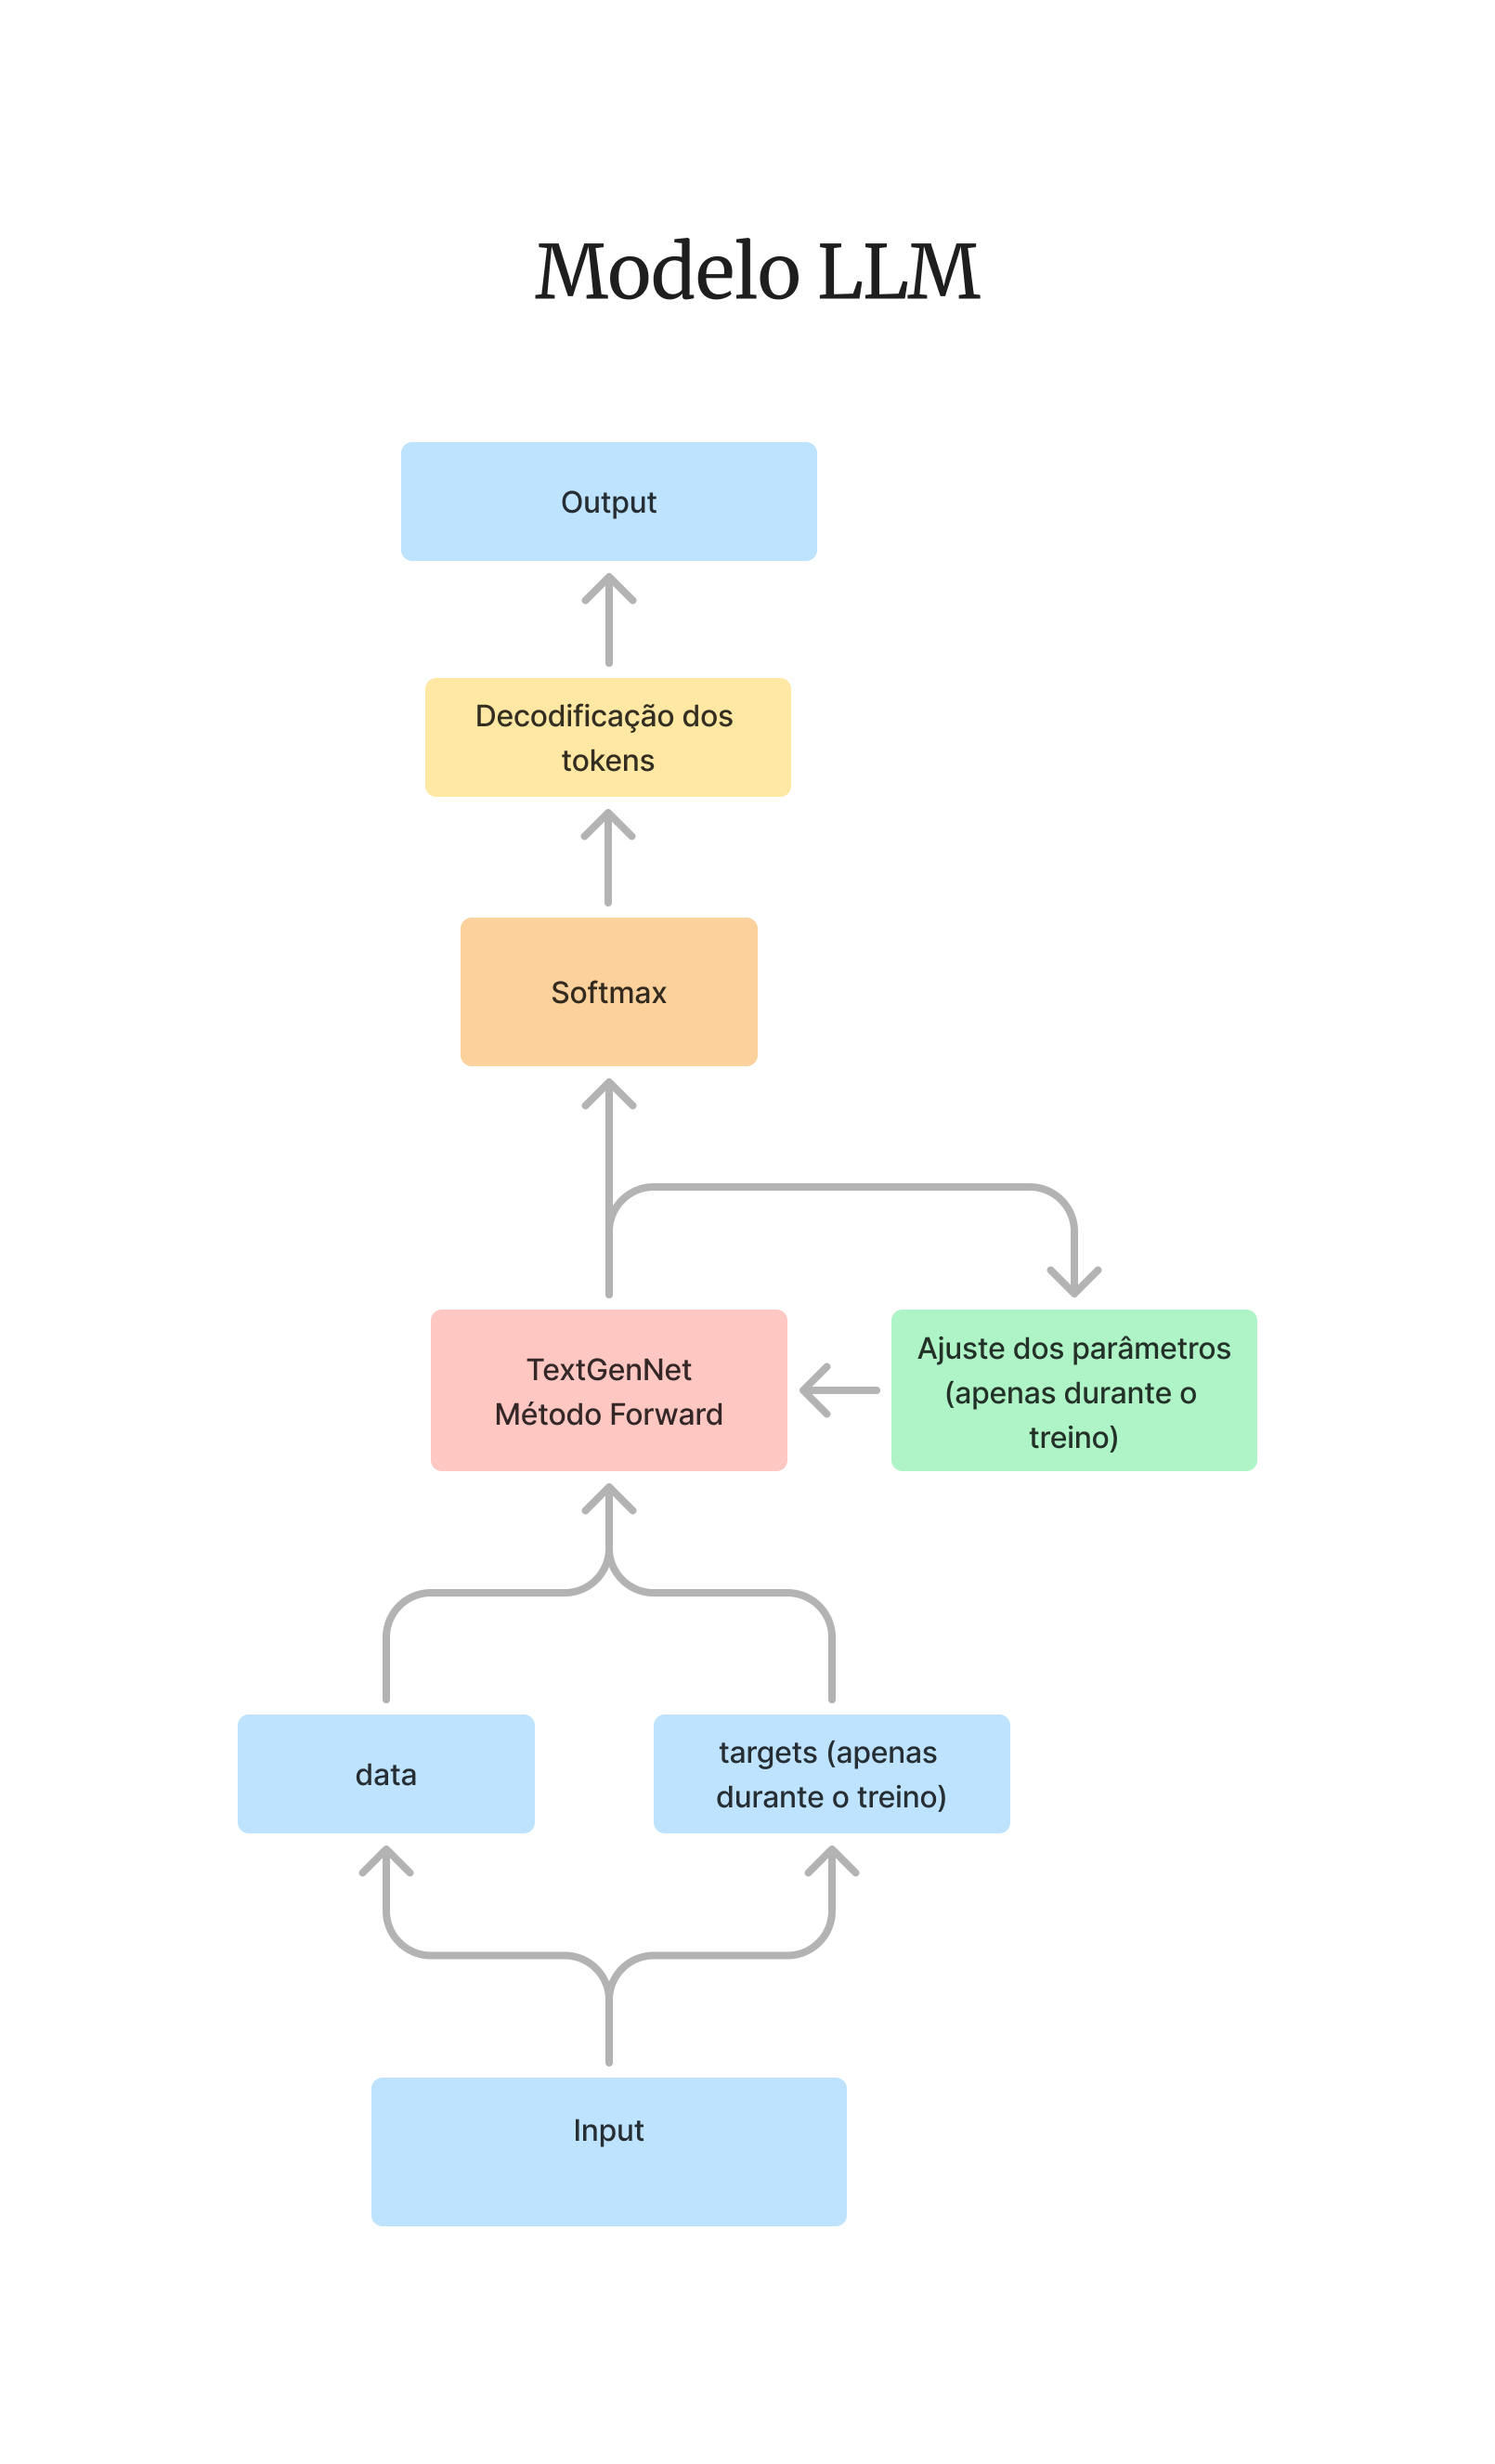

In [9]:
from IPython.display import Image, display
!wget -q "https://raw.githubusercontent.com/elainedias16/TCC/main/assets/llm/Diagrama.png" -O Diagrama.png
display(Image("Diagrama.png", width=500))

A figura abaixo mostra o diagrama do método Forward da Rede Neural de Geração de Textos. No diagrama anterior, foi exibida a entrada para essa rede como data/targets (no contexto de treinamento) ou apenas data (no contexto de teste). Considere essas entradas como tensores. Inicialmente, esse método cria duas representações para esses tensores: uma representação semântica (word embeddings) e uma representação posicional. Essas representações são então somadas e encaminhadas para os blocos do modelo.

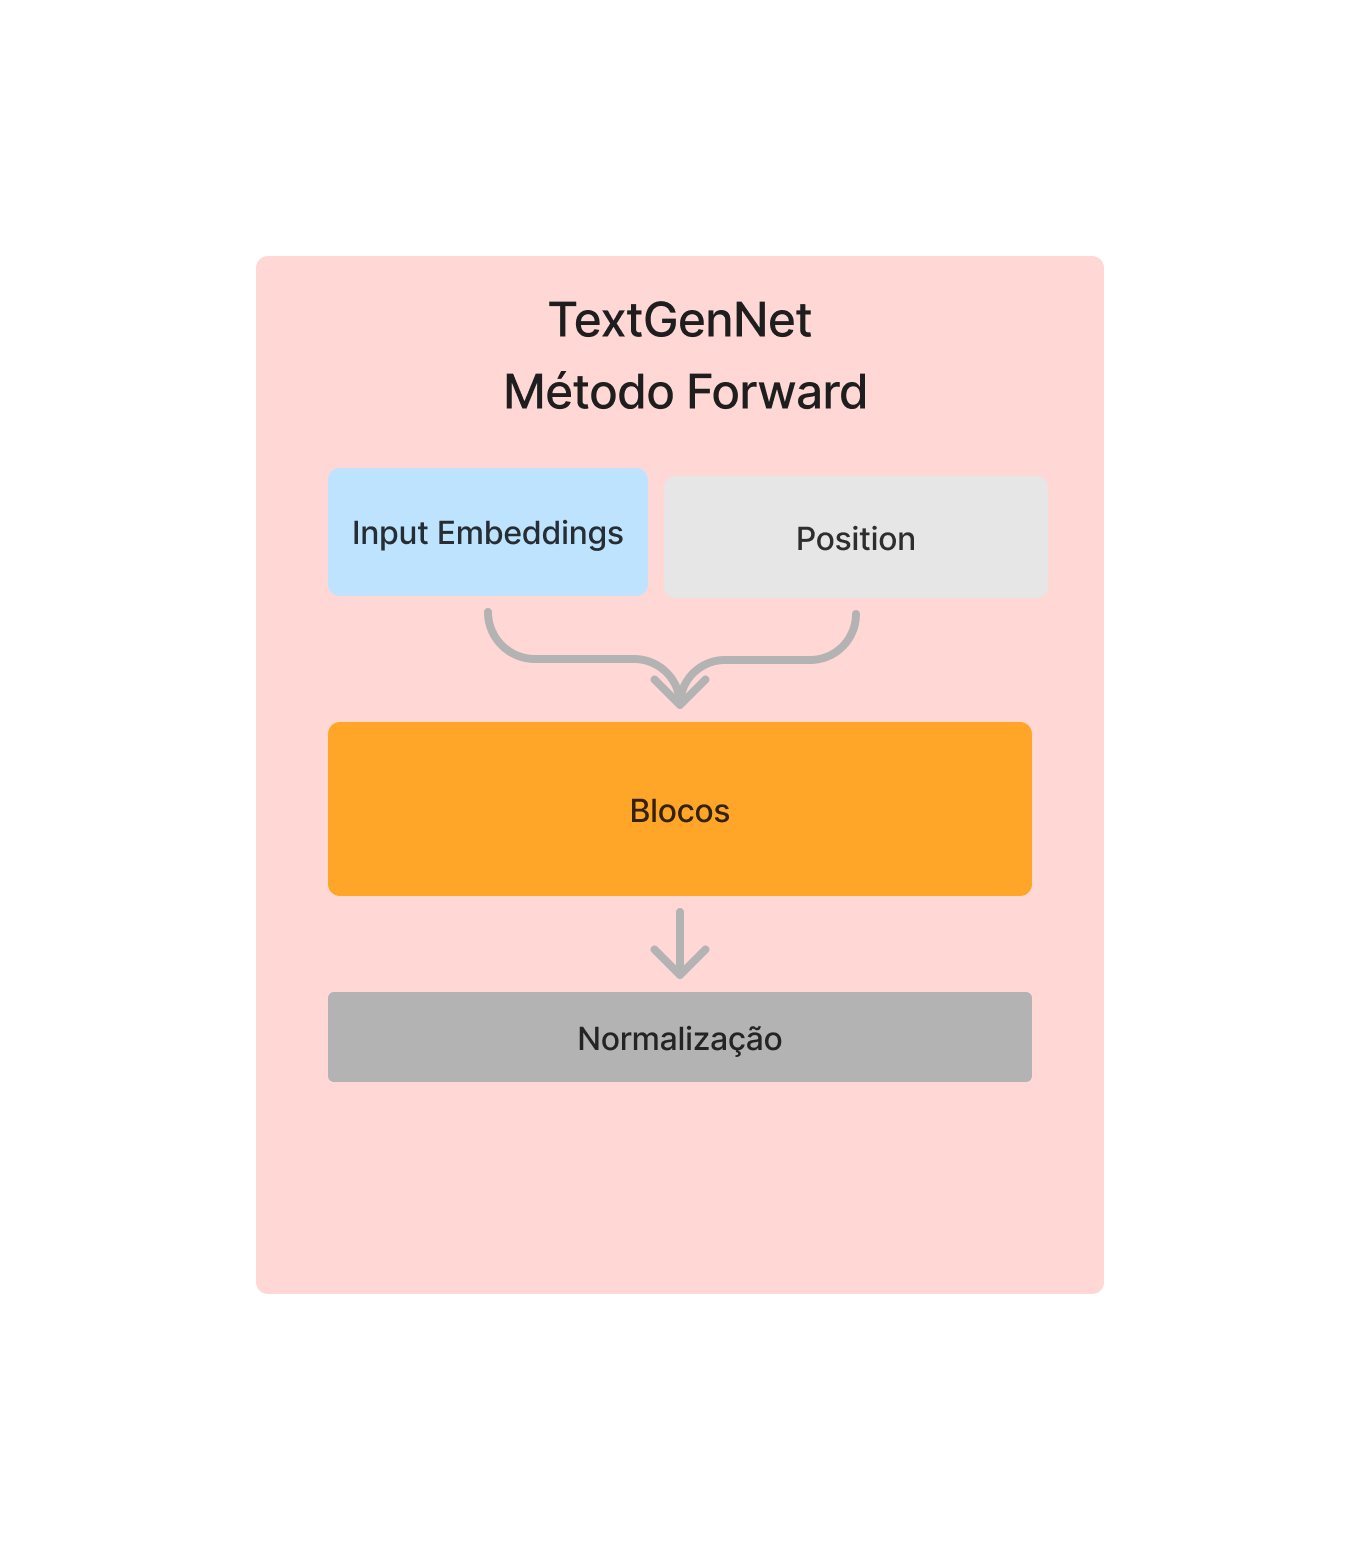

In [1]:
from IPython.display import Image, display
!wget -q "https://raw.githubusercontent.com/elainedias16/TCC/main/assets/llm/genNetForward.png" -O genNetForward.png
display(Image("genNetForward.png", width=400))

Em cada bloco do modelo, a entrada (tok_emb + pos_emb) é normalizado novamente e passa por Muti Head MaskedAttetion, para que sejão realizados os cálculos de atenção.

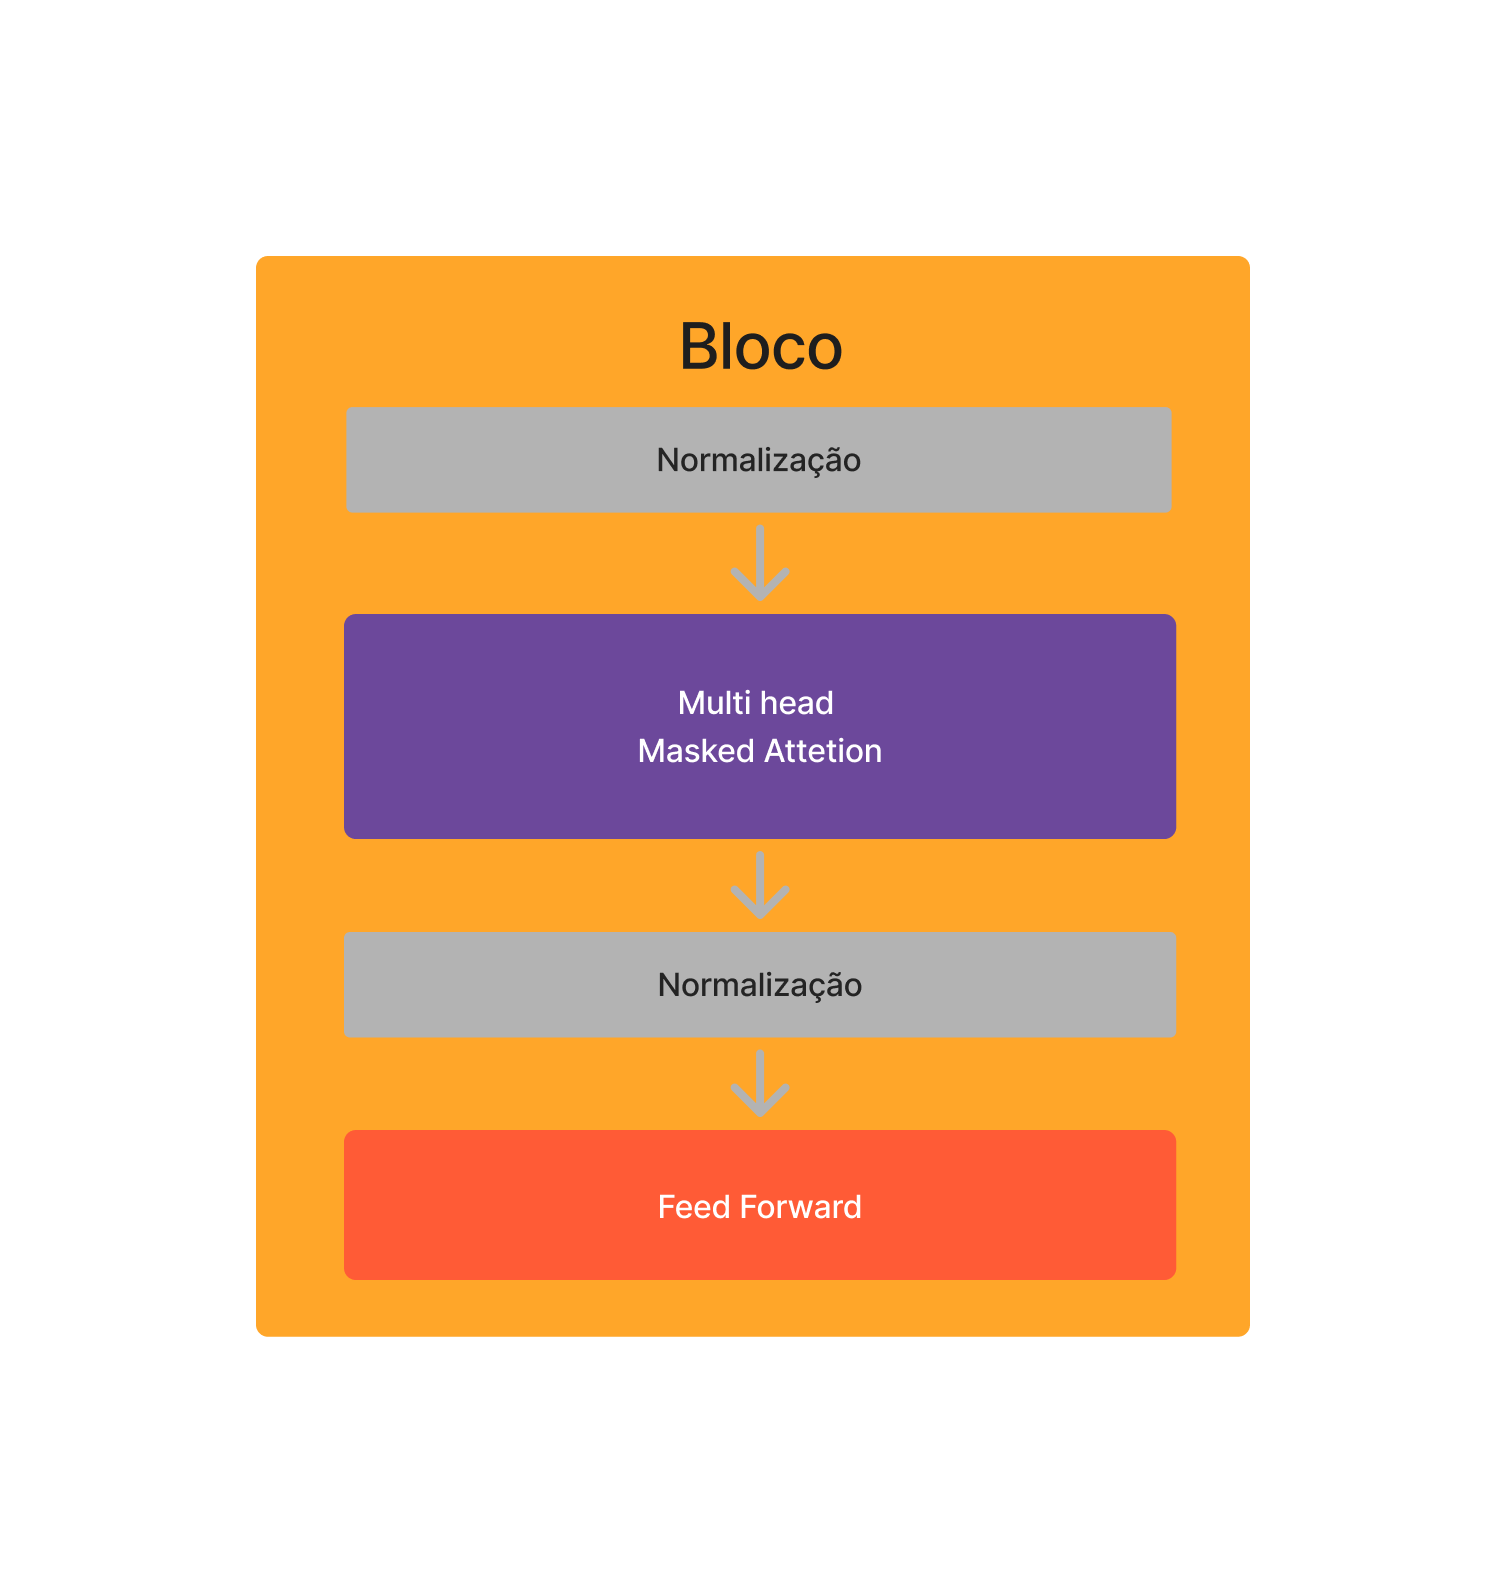

In [17]:
from IPython.display import Image, display
!wget -q "https://raw.githubusercontent.com/elainedias16/TCC/main/assets/llm/block.png" -O block.png
display(Image("block.png", width=450))

A Máscara de Atenção utiliza cabeças de atenção para projetar a entrada em três componentes: consultas (Query), chaves (Key) e valores (Value). Essas projeções são fundamentais para o cálculo de atenção. Antes de apresentar a fórmula desse cálculo, é importante entender o que são essas projeções.

Assim, para cada token da entrada, são realizadas três projeções distintas:

* Q (Query): Representa o token sobre o qual se busca informações. É a consulta que está sendo feita.

* K (Key): É a representação de cada token na sequência, usada para comparar com a Query.

* V (Value): É o valor associado ao token, que será retornado com base na relevância determinada pela comparação entre a Query e as Keys.


Assim, a Query atual é comparada com as Keys dos outros tokens para calcular um score de relevância. Esses scores determinam a importância de cada token para a consulta. Com base nesses scores, o valor (Value) correspondente é selecionado.

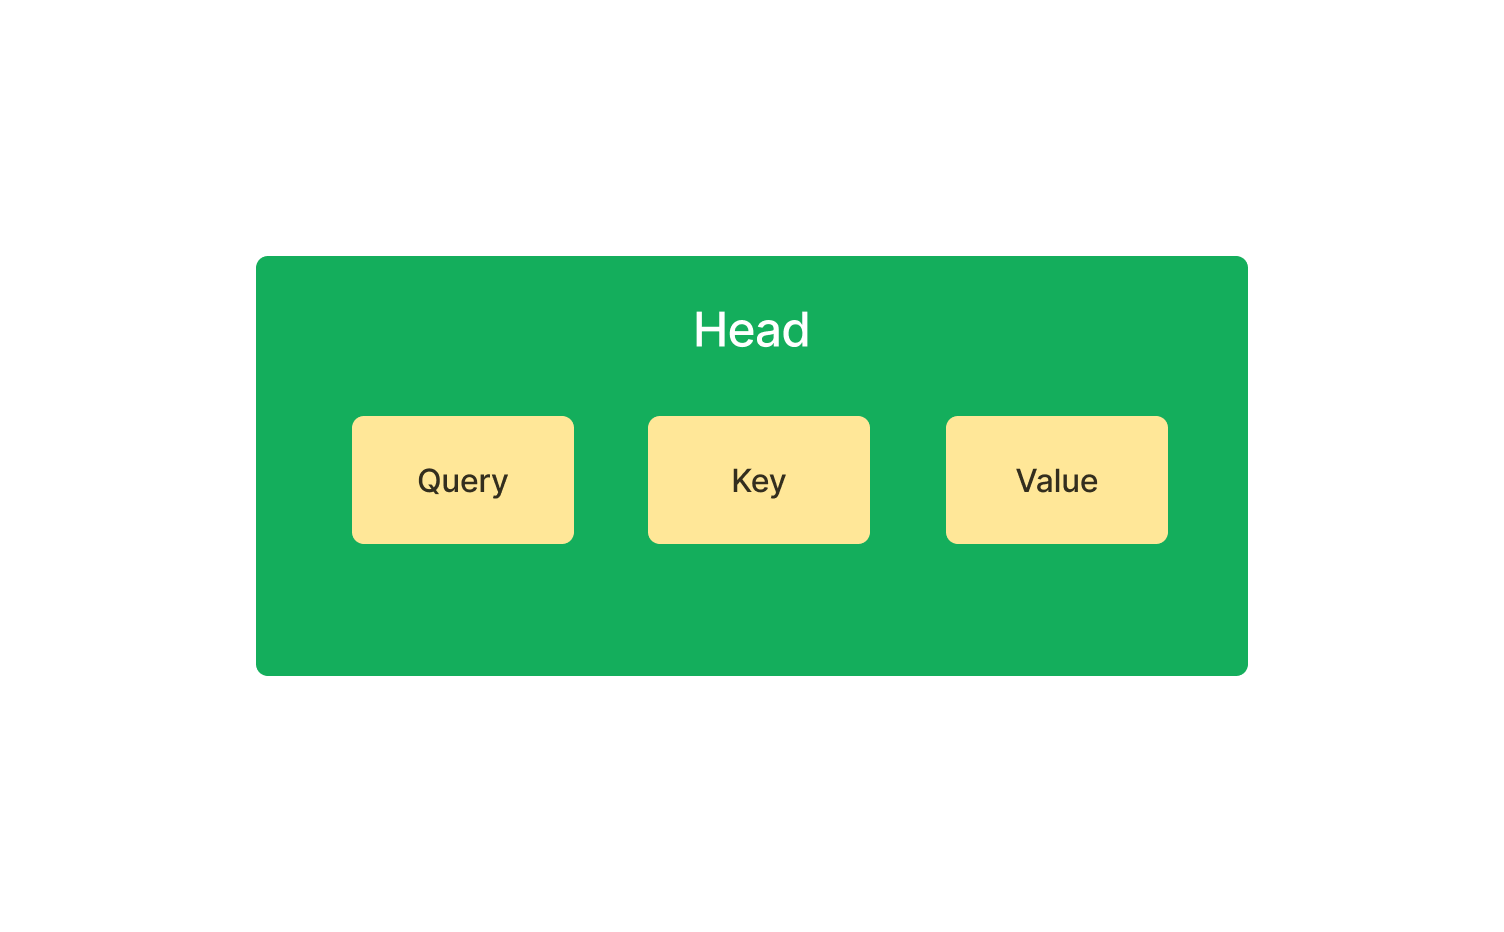

In [16]:
from IPython.display import Image, display
!wget -q "https://raw.githubusercontent.com/elainedias16/TCC/main/assets/llm/head.png" -O head.png
display(Image("head.png", width=400))

A fórmula de atenção é dada por :

$$ Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V $$

Onde:

- \( Q \) representa a **Query** (Consulta),
- \( K \) representa a **Key** (Chave),
- \( V \) representa o **Value** (Valor),
- \( d_k \) é a dimensionalidade das chaves (keys).

Multi-Head Attention: Para capturar diferentes relações entre os tokens, modelos mais avançados utilizam múltiplas cabeças de atenção (multi-head attention). Cada cabeça calcula um conjunto diferente de pesos de atenção, permitindo que o modelo aprenda representações mais ricas e complexas.

Vale ressltar que esse mecanismo é essencial em modelos baseados em tranfomers, sendo o responsǘel por captar as relações entre as palavras. É comum que para obter representações mais ricas e complexas, utilize-se múltiplas cabeças de atenção. Por exemplo, o GPT-3 possui 96 cabeças de atenção em cada camada, sendo que possui 96 camadas!

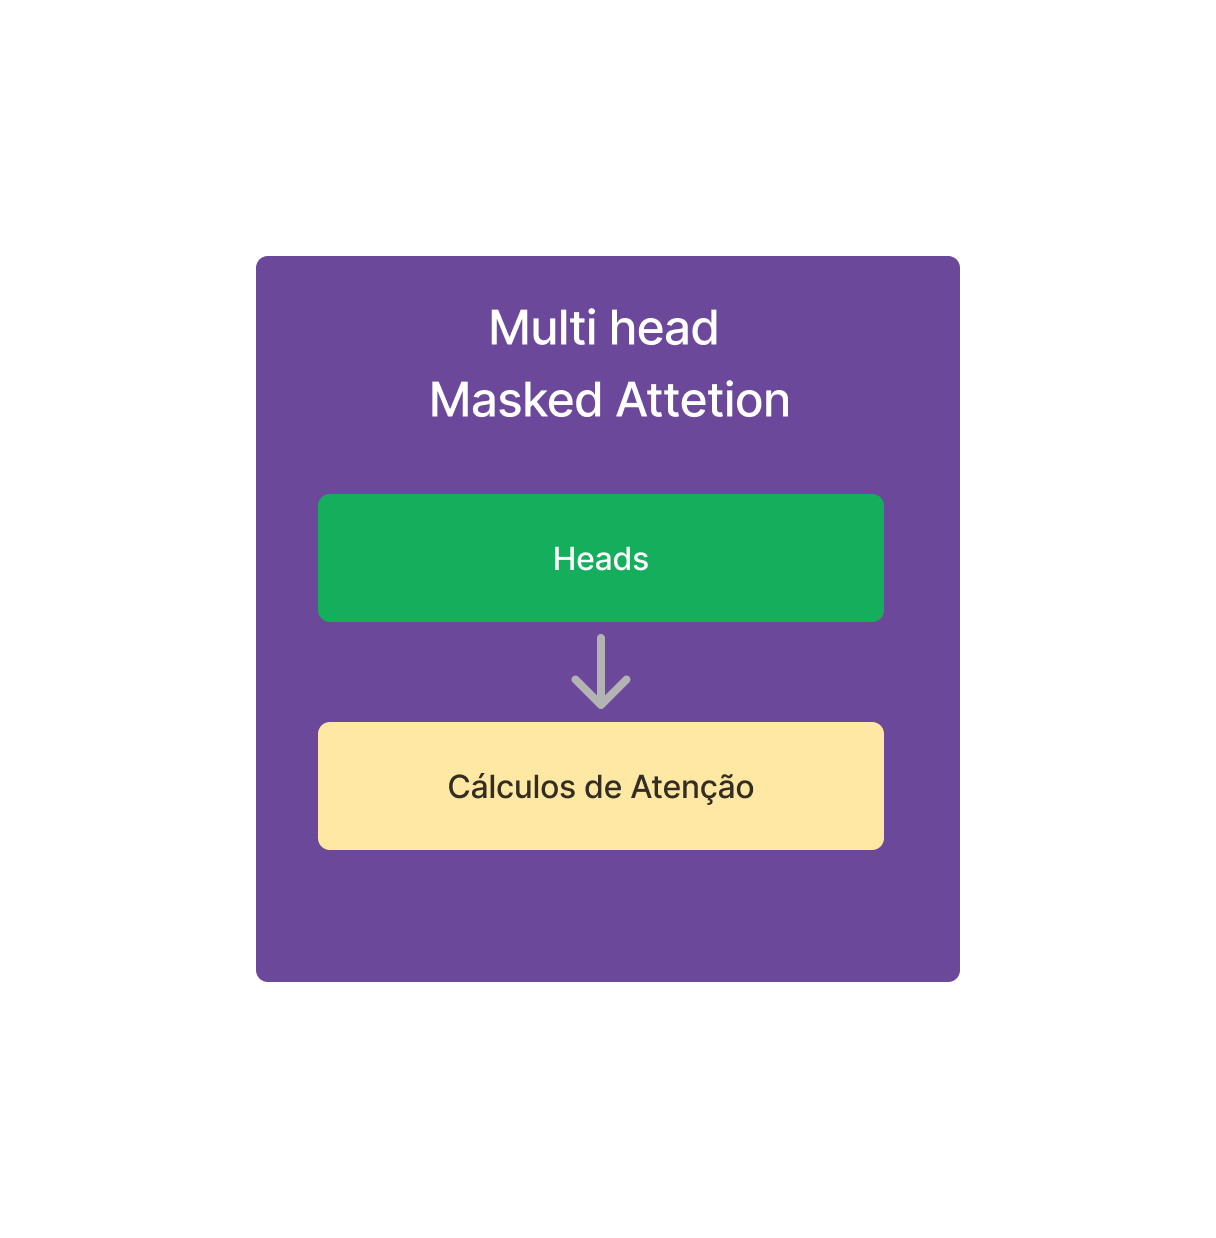

In [15]:
from IPython.display import Image, display
!wget -q "https://raw.githubusercontent.com/elainedias16/TCC/main/assets/llm/masked_attetion.png" -O masked_attetion.png
display(Image("masked_attetion.png", width=350))

Após a saída da máscara de atenção, a saída é normalizada  e segue para uma Rede Feed Forward. Essa rede realiza os seguintes cálculos:


$$ ll1 = W1 \cdot x + b $$
$$ a1 = ReLU(ll1) $$
$$ ll2 = W2 \cdot  a1 + b $$
$$ out = dropout(ll2) $$

Onde :

* ll1 representa a saída da primeira camada linear;
* ll2 representa a saída da segunda camada linear;
* b representa o bias ;
* W representa a matriz dos pesos;
* out representa a saída da rede;


A intenção da função de ativação ReLu é introduzir não linearidade no modelo, buscando saídas mais criativas.


A saída da Rede Feed Forward são os logits e para o modelo está em modo de treino os logits e a loss. Assim, após essa rede, há uma bifurcação de como proseguiremos.


A saída da Rede Feed Forward são os logits, e no modo de treinamento, essa saída é usada junto à função de perda (loss) para ajustar os parâmetros do modelo. Assim, após essa rede, ocorre uma bifurcação no fluxo: no contexto de treinamento, os logits são comparados com os targets para calcular a loss, enquanto no teste, os logits são processados para gear a predição final.

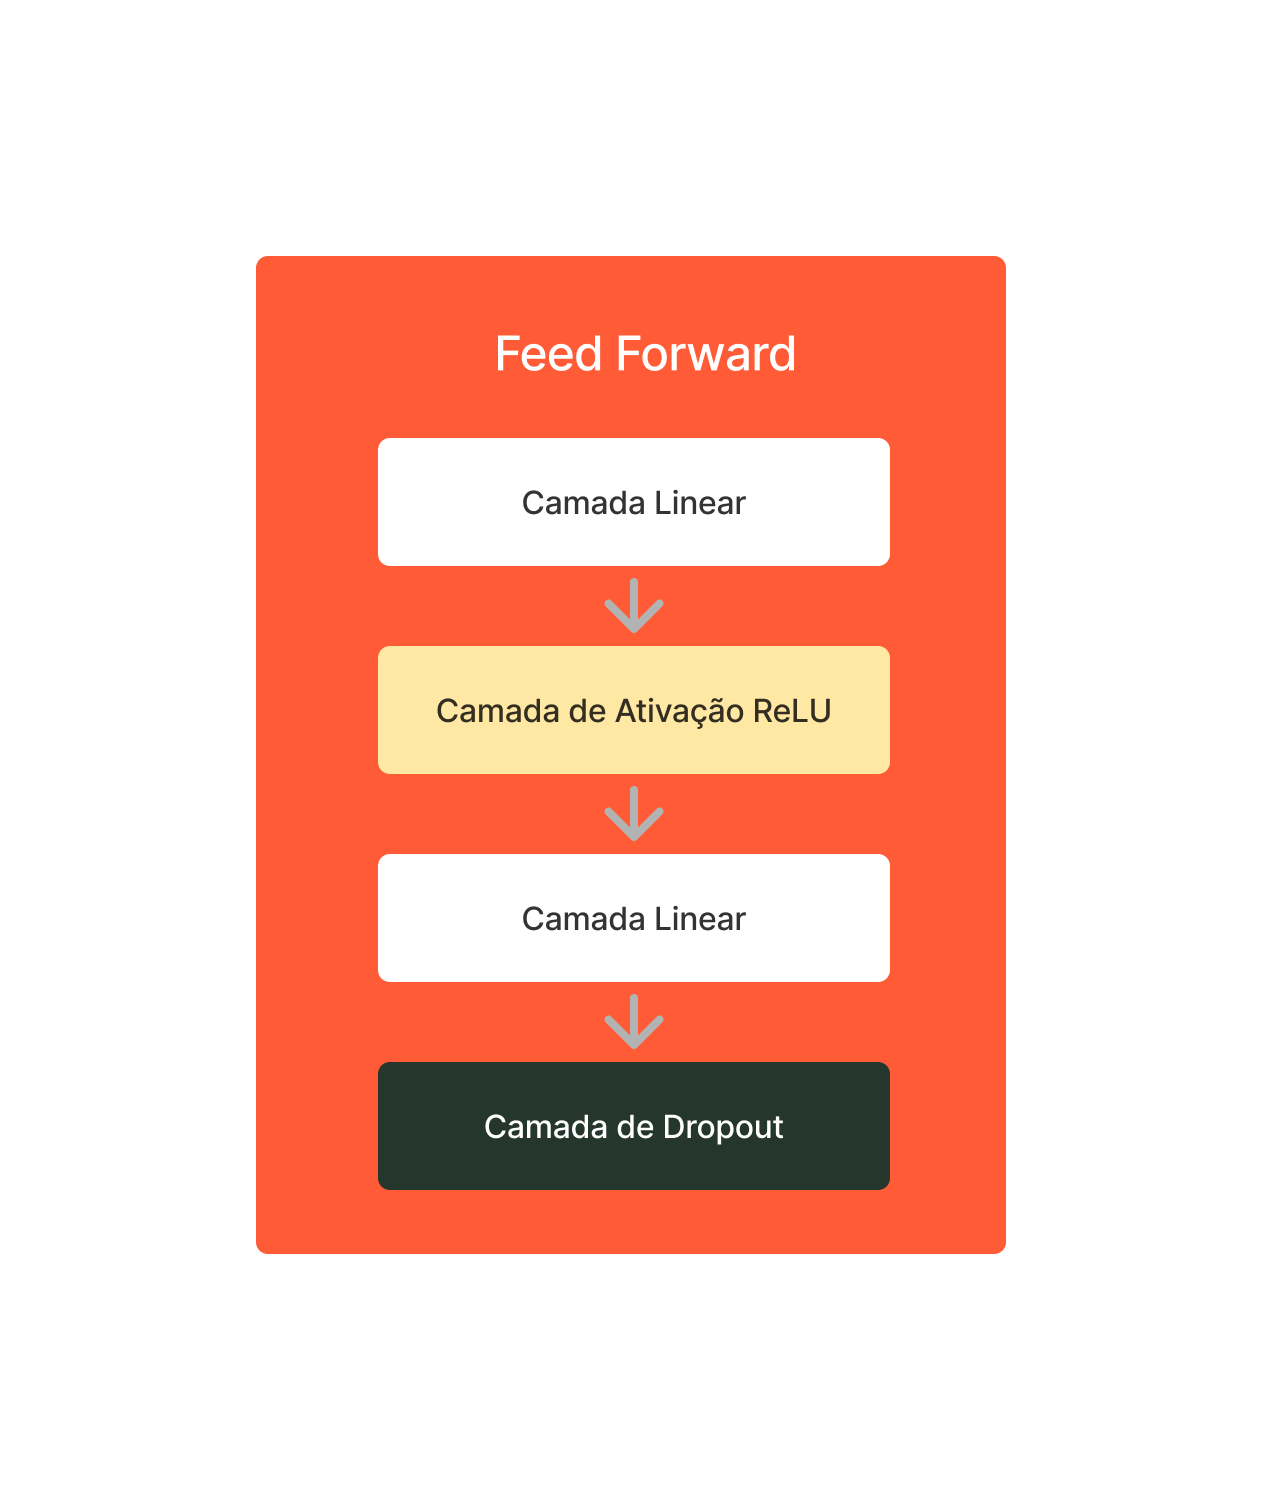

In [8]:
from IPython.display import Image, display
!wget -q "https://raw.githubusercontent.com/elainedias16/TCC/main/assets/llm/feedforward.png" -O feedforward.png
display(Image("feedforward.png", width=350))

Assim, no contexto de treinamento, é utilizado a Função de Entropia cruzada entre os logits preditos e os logits targets para calcular a perda. A fórmula da entropia cruzada é dada por:

$$
H(p, q) = - \sum_{i=1}^{N} p_i \log(q_i)
$$

onde:

- $N$ é o número total de tokens no vocabulário;
- $p_i$ é a probabilidade real do token $i$ ;
- $q_i$ é a probabilidade predita pelo modelo para o token $i$ .


onde:
- \(\text{shift\_logits}\) representa os logits de predição.
- \(\text{shift\_targets}\) representa os rótulos alvo.
- \(\text{view(-1)}\) achata as entradas em um vetor 1D.
- A função de entropia cruzada compara os logits com os alvos após esse achatamento para calcular a perda.

Figura 1: Diagram Geral

## Código

O código abaixo realiza a instalação e importação das bibliotecas necessárias para o desenvolvimento do modelo LLM. A principal biblioteca utilizada será o PyTorch, que fornece os módulos essenciais para redes neurais e otimização, através dos pacotes torch.nn e torch.optim, respectivamente. O otimizador importado é o Adam.

Para realizar os cálculos de atenção, são importadas as bibliotecas math e functional. Também são importadas as bibliotecas Dataset e DataLoader para a criação e manipulação de datasets e mini-lotes durante o treinamento. Além disso, a biblioteca Counter, da coleção padrão, e a nltk são utilizadas para contagem e pré processamento de dados, com nltk incluindo o método word_tokenize para tokenização.


Vale ressaltar que é possível criar um modelo LLM com outras bibliotecas, por exemplo, a Keras. A escolha da biblioteca Torch foi devido a maior familiaridade com a mesma.

In [ ]:
!pip install transformers torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import torch.nn.functional as F
from torch.optim import Adam
import math

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Máscara de Atenção

A classe abaixo define uma cabeça de atenção do modelo LLM. Uma cabeça de atenção é responsável por realizar a projeção linear dos valores de entrada para obter as chaves (key), consultas (query) e valores (value). Optou-se por realizar os cálculos de atenção na classe seguinte.

In [ ]:
class Head(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.query = nn.Linear(config.d_model, config.head_dim, bias=config.bias)
    self.key = nn.Linear(config.d_model, config.head_dim, bias=config.bias)
    self.value = nn.Linear(config.d_model, config.head_dim, bias=config.bias)


  def forward(self, x):
    q = self.query(x)
    k = self.key(x)
    v = self.value(x)
    return q, k, v


A classe abaixo realiza o mecanismo de auto atenção, que é essencial em modelos baseados em Transformers.

Na inicialização, a classe define o número de cabeças de atenção, a dimensão de cada cabeça e a dimensão do modelo. A dimensão de cada cabeça é escolhida de forma que a soma das dimensões de todas as cabeças seja igual à dimensão do modelo. Também é definido uma camada de dropout, uma camada de saída e as cabeças de atenção.

Em seguida, é criado um método de forward, que itera sobre cada cabeça para realizar os cálculos de atenção. Assim, a fórmula de atenção "Scaled dot-product attention" é aplicada e os resultados são concatenados. Por fim, esses resultados passam pela camada linear de saída e são retornados.

In [ ]:
class MaskedSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_heads = config.num_heads
        self.head_dim = config.head_dim
        self.dropout = nn.Dropout(config.dropout)
        self.d_model = config.d_model
        self.heads = nn.ModuleList([Head(config) for _ in range(config.num_heads)])
        self.output_linear = nn.Linear(config.d_model, config.d_model)
        assert self.head_dim * self.num_heads == self.d_model, "d_model must be divisible by num_heads"


    def forward(self, x, mask=None):
        # B, T, C = x.size()

        heads_output = []
        for head in self.heads:
            k, q, v = head(x)


            # Scaled dot-product attention
            scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

            if mask is not None:
                scores = scores.masked_fill(mask == 0, float('-inf'))

            attn_weights = F.softmax(scores, dim=-1)
            attn_weights = self.dropout(attn_weights)

            head_output = torch.matmul(attn_weights, v)
            heads_output.append(head_output)


        concatenated_output = torch.cat(heads_output, dim=-1)
        output = self.output_linear(concatenated_output)

        return output




### Rede Neural Feed Forward - Multilayer Perceptron (MLP)

O código abaixo implementa uma Rede Feed-Forward. A arquitetura inclui uma camada de ativação, uma camada de dropout e duas camadas lineares. Inicialmente, a entrada é processada pela primeira camada linear, seguida pela aplicação da função de ativação. Em seguida, a saída da ativação passa pela camada de dropout para regularização e finalmente, a rede aplica a segunda camada linear, produzindo a saída final do modelo.

Foi escolhida a função de ativação ReLU, mas poderia escolher-se outras como GeLU. O bias para o cálculo da transformação matricial é definido como parâmetro e também é definido um aumento de dimensinalidade nos dados para tentar captar melhor a complexidade dos dados. Na última camada linear, é feito a redução da dimensionalidade.

In [ ]:
class FeedFoward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.linear1 = nn.Linear(config.d_model, 4 * config.d_model, bias=config.bias)
    self.activation = nn.ReLU()
    self.linear2 = nn.Linear(config.d_model * 4,  config.d_model, bias=config.bias)
    self.dropout = nn.Dropout(config.dropout)

  def forward(self, x):
    x = self.linear1(x)
    x = self.activation(x)
    x = self.linear2(x)
    x = self.dropout(x)
    return x



### Normalização

A classe abaixo é responsável pela normalização do modelo. Assim, são definidas duas camadas de normalização com o intuito de estabilizar o modelo e melhorar o treinamento.

In [ ]:
class LayerNorm(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.norm1 = nn.LayerNorm(config.d_model, config.bias)
    self.norm2 = nn.LayerNorm(config.d_model, config.bias)

  def forward(self, x):
    x = self.norm1(x)
    x = self.norm2(x)
    return x

### Bloco

A classe Block define um bloco básico de um modelo LLM, que integra a normalização, a atenção e uma Rede Feed-Forward (MLP).

Assim, no método forward, a entrada é primeiro normalizada, depois processada pela camada de atenção e somada à entrada original para formar uma conexão residual. Em seguida, o resultado é novamente normalizado e passado pela Rede Feed-Forward, que também é adicionada à saída anterior, com o intuito de aumentar a eficácia do modelo.

In [ ]:
class Block(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.ln_1 = LayerNorm(config)
    self.masked_self_attention = MaskedSelfAttention(config)
    self.ln_2 = LayerNorm(config)
    self.feed_forward = FeedFoward(config)

  def forward(self, x):
    x = self.ln_1(x)
    x = x + self.masked_self_attention(x)
    x = self.ln_2(x)
    x = x + self.feed_forward(x)
    return x



### Text Generator Network (Rede de Geração de Texto)



https://medium.com/@hunter-j-phillips/positional-encoding-7a93db4109e6#:~:text=class%20PositionalEncoding(nn,self.dropout(x)
olhar posiitional

O código abaixo agrega os componentes criados anteriormente e adiciona os restantes para o funcionamento do modelo LLM.

Na inicialização da classe, o parâmetro config define as configurações do modelo. São criados os blocos de Transformer, a camada de normalização LayerNorm, bem como as camadas de embeddings de tokens e de posição, uma camada de dropout e uma camada linear final.

Em seguida são criados dois métodos, o "forward" e o "generate". O método "forward" define o fluxo de dados pela rede, sendo seus parâmetros os input_ids e opcionalmente os targets. O parâmetro targets foi definido como optional (targets=None), para o caso do teste do modelo, no qual os targets não são necessários. Os input_ids correspondem as palavras, que quando chegam nesse ponto do código já estão em formato de tensores PyTorch.

Em seguida, é definido uma variável de device que recebe o mesmo device de onde estão os tensores de entrada (palavras => tokens => input_ids => tensor) . Isso é feito para garantir que os cálculos ocorram no mesmo dispostivo.

As variáveis B e T armazenam o tamanho do batch e o comprimento da sequência, respectivamente. Após isso, o tensor de entrada passa pela camada de embeddings, de forma que cada token passa a ter uma representação vetorial de dimensão d_model.  A camada de embeddings posicional é usada para incorporar a ordem dos tokens na sequência, sendo utilizado o comprimento da sequência (T) como parâmetro para gerar a incorporação posicional. As representações vetoriais dos tokens e suas posições são somadas (tok_emb + pos_emb) para gerar a entrada final x. Essa soma combina o significado semântico dos tokens com sua posição na sequência, o que permite ao modelo aprender tanto o contexto quanto a ordem relativa dos tokens.  Após isso, a soma (tok_emb + pos_emb) passa por uma camada de dropout para reduzir a chance de overting.


Após a camanda de dropout, os dados passam pelos blocos que foram explicados anteriormente. Assim, os dados passam por n_layer blocos. Em seguida, os dados passam pela camada de normalização e pela camada linear final, a qual produz os logits, que são os valores brutos da classificação gerada.

Para o contexto de treinamento, é adicionado algumas linhas abaixo para realizar o o cálculo da perda (loss) por meio entropia cruzada, sendo que a loss calculada será utilizada para ajustar os parâmetros do modelo durante a otimização.  Para realizar o cálculo da loss, são comparados os logits preditos na classificação (shifits_logits) e os logits reais(shift_targets). Antes de fazer a comparação, é necessário ajustar os tensores. É preciso remover a última posição dos shift_logits e a primeira posição dos shift_targets. Isso ocorre porque o primeiro token de shift_targets não tem um token anterior para ser previsto, e o último logit de shift_logits não precisa prever nada, já que não há tokens após ele. Dessa forma, as previsões são alinhadas com os targets corretos para calcular a loss.

Dessa forma, no modo de treinamento, as saídas são os logits e a loss. Para o contexto de teste, há também o método "generate". Esse método realiza um loop com o número máximo de tokens a serem gerados, chamando o método de "forward" em cada iteração. É criado um array de output_ids para armazenar os outputs do método de forward , os quais serão apenas os logits, pois no modo teste não há targets e portanto não há como calcular a loss. Uma vez que os outputs do método forward são os logits , é preciso passar esses logits por uma função de softmax de forma a gerar um vetor de probabilidades do próximo token da sentença, sendo que o ID do token de maior probabilidade é escolhido e armazenado no array output_ids. Em seguida, o token gerado é concatenado à sentença de entrada formando um novo input_ids e assim o loop continua até o máximo de número de tokens ser atingido. Por fim, o array de output_ids é retornado e precisará passar pelo método de "decode" para ser interpreta em linguagem natural.

In [ ]:
class TextGenNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.word_token_embedding = nn.Embedding(config.vocab_size, config.d_model)
        self.position_embedding = nn.Embedding(config.max_length, config.d_model)
        self.dropout = nn.Dropout(config.dropout)
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        self.ln = LayerNorm(config)
        self.ll = nn.Linear(config.d_model, config.vocab_size, bias=False)

    def forward(self, input_ids, targets=None):
        device = input_ids.device
        B, T = input_ids.size()

        # Positional e token embed
        tok_emb = self.word_token_embedding(input_ids)
        pos_emb = self.position_embedding(torch.arange(T, device=device))
        x = self.dropout(tok_emb + pos_emb)

        # Transformer blocks
        x = self.blocks(x)

        # Norm layer
        x = self.ln(x)

        # Final layer
        logits = self.ll(x)

        if targets is not None:
            shift_logits = logits[:, :-1, :].contiguous()
            shift_targets = targets[:, 1:].contiguous()
            loss = F.cross_entropy(shift_logits.view(-1, shift_logits.size(-1)), shift_targets.view(-1))
            return logits, loss

        return logits, None


    # def generate(self, input_ids, max_new_tokens):
    #   output_ids = []

    #   for _ in range(0, max_new_tokens):
    #       input_ids_cond = input_ids[:, -self.config.block_size:]
    #       logits, _ = self.forward(input_ids_cond)
    #       logits = logits[:, -1, :]
    #       print(f"logits: {logits}")
    #       probs = F.softmax(logits, dim=-1)
    #       print(f"probs: {probs}")
    #       input_ids_next = torch.multinomial(probs, num_samples=1)
    #       print(f"input_ids_next: {input_ids_next}")
    #       output_ids.append(input_ids_next)
    #       input_ids = torch.cat((input_ids, input_ids_next), dim=1)

    #   output_ids = torch.cat(output_ids, dim=1)
    #   print(f"output_ids: {output_ids}")
    #   return output_ids


    def generate(self, input_ids, max_new_tokens):
      output_ids = []

      for i in range(max_new_tokens):
          print(f"\n=== Token {i + 1} ===")

          # Condiciona a entrada com base no tamanho do bloco
          input_ids_cond = input_ids[:, -self.config.block_size:]

          # Passa pelos blocos Transformer
          logits, _ = self.forward(input_ids_cond)

          # Considera apenas o último token da sequência gerada até agora
          logits = logits[:, -1, :]
          print(f"Logits (raw scores): {logits}")

          # Aplica softmax para converter em probabilidades
          probs = F.softmax(logits, dim=-1)
          print(f"Probabilidades: {probs}")

          # Encontra a maior probabilidade e o token correspondente
          max_prob, max_token_id = torch.max(probs, dim=-1)
          print(f"Maior probabilidade: {max_prob.item()} (Token ID: {max_token_id.item()})")

          # Gera o próximo token a partir das probabilidades
          input_ids_next = torch.multinomial(probs, num_samples=1)
          # input_ids_next = max_token_id.unsqueeze(-1)
          print(f"Próximo token gerado (input_ids_next): {input_ids_next.item()}")

          # Armazena o próximo token gerado
          output_ids.append(input_ids_next)

          # Atualiza a sequência de entrada com o novo token
          input_ids = torch.cat((input_ids, input_ids_next), dim=1)

      # Concatena todos os tokens gerados em uma sequência final
      output_ids = torch.cat(output_ids, dim=1)
      print(f"Sequência completa gerada (output_ids): {output_ids}")

      return output_ids



### Configurações do modelo

O código abaixo define os parâmetros gerais para o treinamento do modelo LLM. Assim, são definidos o dispositivo que será utilizado, o número máximo de tokens a serem gerados, o número de épocas de treinamento, a taxa de aprendizado do otimizador do modelo (será utilizado o otimizador Adam), o tamanho dos lotes de treinamento e o tamanho da sequência de entrada do modelo.



In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
max_new_tokens = 50
epochs = 100
learning_rate = 0.001
batch_size = 8
SEQUENCE_LENGTH = 64

O código abaixo define os parâmetros que definem a arquitetura do modelo. Assim, são definidos o número de cabeças para os cálculos de atenção, a dimensão do modelo, a dimensão de cada cabeça de atenção, a taxa de dropout para evitar overfitting, a presença ou não de bias, o tamanho do vocabulário, o tamanho máximo da sequência de entrada, o número de camadas do modelo, isto é, quantos blocos o modelo terá, e o tamanho do bloco de entrada.

In [ ]:
class Config:
    num_heads = 2
    d_model = 64
    head_dim = 32
    dropout = 0.1
    bias = True
    vocab_size = 50257      # Len tokenizer (for now)
    # hidden_size = 1024
    max_length = 512
    n_layer = 6
    block_size = SEQUENCE_LENGTH
    # block_size = 1024
    # block_size = 32


config = Config()

### Treinamento

O código abaixo faz o download do dataset "alice.txt" .  Em seguida, é realiza a leitura do arquivo, utilizando a função open() para abrir o arquivo no modo de leitura ('r') e com codificação UTF-8. O conteúdo completo do arquivo é lido e armazenado na variável text.

In [ ]:
# !wget https://raw.githubusercontent.com/elainedias16/TCC/main/alice_1.txt

# with open('alice_1.txt', 'r', encoding='utf-8') as f:
#     text = f.read()

In [ ]:
text = "Sofia era uma menina quieta e introspectiva, mas havia algo nela que todos sabiam: seu amor pelos livros. Desde muito pequena, tinha uma curiosidade insaciável pelo mundo ao seu redor. Aos cinco anos, já estava folheando livros com ilustrações, fascinada pelas imagens e pelas poucas palavras que conhecia. À medida que crescia, essa paixão só aumentava. Seus pais a encontravam, todos os dias, escondida em algum canto da casa com um livro nas mãos, como se estivesse em outro mundo. Na escola, Sofia não era a criança mais extrovertida, mas os livros lhe davam confiança. Enquanto os colegas brincavam no pátio, ela preferia a biblioteca. A bibliotecária, Dona Clara, rapidamente se tornou sua amiga e confidente. Dona Clara sabia exatamente quais livros indicar para cada fase de Sofia. Desde contos de fadas clássicos até aventuras fantásticas, cada novo livro era uma porta para um mundo cheio de magia e descobertas. Sofia gostava de se imaginar como as protagonistas das histórias que lia. Às vezes, ela era uma exploradora destemida, em outras, uma princesa corajosa que lutava contra o mal. Mas o que mais a fascinava eram as palavras. Ela não apenas lia, mas sentia cada frase, cada parágrafo como se fosse parte da sua própria vida. Isso a inspirou a começar a escrever suas próprias histórias. No começo, suas histórias eram simples, contos sobre princesas, dragões e reinos distantes. No entanto, à medida que crescia, seus escritos se tornaram mais profundos. Ela começou a explorar temas sobre amizade, coragem e superação. Aos 12 anos, já tinha um caderno cheio de histórias que criava, e sonhava, um dia, em publicar seus próprios livros. Para Sofia, ler não era apenas um hobby; era a chave que a conectava a um mundo infinito de imaginação e conhecimento."

O método abaizo faz a tokenização de um texto, além de tranformar os caracteres em caracteres minúsculos.

In [ ]:
def tokenize(text):
  return word_tokenize(text.lower())

O código abaixo cria os dicionários de codificação e decodificação das palavras, além de retornar o tamanho do vocabulário. Para criar esses dicionários, é utilizado o método "Counter", que contabiliza a quantidade de  cada palavra no conjunto de tokens fornecidos. Em seguida, é criada uma lista auxiliar contendo as palavras únicas do vocabulário. O dicionário "word_to_int" é então gerado, associando cada palavra a um índice numérico com base em sua posição no vocabulário, e o dicionário "int_to_word" faz o mapeamento inverso, associando os índices às palavras correspondentes.

In [ ]:
def build_vocab(tokens):
  word_counts = Counter(tokens)
  vocab = list(word_counts.keys())
  word_to_int = {word: i for i, word in enumerate(vocab)}
  int_to_word = {i: word for word, i in word_to_int.items()}

  return len(vocab), word_to_int, int_to_word

O código abaixo cria as amostras de entrada e saída para o modelo LLM. Uma vez que o dataset é apenas um conjunto de palavras, é necessário separar as palavras em data/target para que seja possível realizar o treinamento. Para isso, são passados os tokens , o dicionário de codificação de palavras e o tamanho da sequência de entrada do modelo.

Inicialmente, os tokens são codificadores em IDs e são criadas amostras (samples) desses tokens. As amostras são criadas a partir da lista "encoded" criada anteriormente, no formato "i : i +  sequence_length + 1", que significa que para cada posição de i dos tokens será criada uma amostra de tamanho de sequence_length + 1, começando a sequência de tokens a partir do token i. Essas amostras são criadas em um loop de tamanho "len(encoded) - sequence_length", para que não "estore" o tamanho da lista ao acessar tokens muito perto do final, pois não é possível criar uma amostra de tamanho "sequence_length + 1", acessando o penúltimo token da lista, por exemplo, por isso não é possível iterar sobre toda a lista de tokens para criar amostras.



Após isso, todos os tokens de cada amostra (sequence_length + 1) menos os últimos são armazenados na variável data e convertidos em um tensor, sendo que os últimos tokens de cada amostra são armazendos na variável targets e convertidos em um tensor.

Esse método codifca os texto para o treinamento.


In [ ]:
def prepare_data(tokens, word_to_int, sequence_length=64):
  encoded = [word_to_int[token] for token in tokens]
  samples = [encoded[i:i + sequence_length + 1] for i in range(len(encoded) - sequence_length)]
  data = torch.tensor([sample[:-1] for sample in samples], dtype=torch.long)
  targets = torch.tensor([sample[1:] for sample in samples], dtype=torch.long)
  return data, targets

O código abaixo define a classe TextDataset, que herda da classe Dataset do PyTorch. O objetivo dessa classe é organizar o dataset em dois componentes: data e targets. Além disso, foi criado o método "getitem", que dado um índice, retorna uma tupla contendo o dado e o target correspondente. Também foi criado o método "len", que retorna o tamanho total do conjunto de dados. Posteriomente, essa classe será utilizada para instanciar um DataLoader.

In [ ]:
class TextDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

O método abaixo realiza o treinamento do modelo. Ele recebe como parâmetros o modelo, o otimizador, o número de épocas de treinamento e o dataloader. Incialmente, o modelo é configurado em modo de treinamento e um loop é criado para iterar pelas épocas, com a perda total sendo inicializada em $0$. Para cada conjunto de input_ids e targets fornecido pelo dataloader, o modelo é chamado e calcula-se os logits e a perda. Em seguida, realiza-se a retropropagação da perda e a atualização dos pesos. A perda de cada lote é somada à perda total, e ao final de cada época, o valor médio da perda é exibido.

In [ ]:
def train_model(model, dataloader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for input_ids, targets in dataloader:
            optimizer.zero_grad()
            logits, loss = model(input_ids, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader)}")

O código abaixo faz a instanciação do modelo e do otimizador que será utilizadado.

In [ ]:
model = TextGenNet(config)
optimizer = Adam(model.parameters(), lr=learning_rate)

O código abaixo faz a tokenizaçao do dataset e chama o método de criar o vocabulário, o qual retorna os dicionários de codificação e decodificação das palavras e o tamanho do vocabulário. Em seguida, é ajustado o tamanho do vocabulário nas configurações do modelo , pois o tamanho deixado como default  é o tamanho do tokenizador gpt-tokenizer.

In [ ]:
tokenize_text = tokenize(text)
vocab_size, word_to_int, int_to_word = build_vocab(tokenize_text)

config.vocab_size = vocab_size

O código abaixo chama o método "prepare_data" que separa o texto do dataset em data e targets, para que seja possível realizar o treinamento do modelo.

In [ ]:
data, targets = prepare_data(tokenize_text, word_to_int)

O código abaixo define um objeto do tipo TextDataset, adequado para manipular dados textuais. Em seguida, é criado um DataLoader, que permite realizar o treinamento em mini-lotes (mini-batches). O tamanho de cada lote é determinado pela variável batch_size. O parâmetro shuffle=True indica que os dados serão embaralhados a cada época de treinamento, o que contribui para a melhor generalização do modelo.

In [ ]:
dataset = TextDataset(data, targets)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

O código abaixa chama o método de "train_model" que realiza o treinamento do modelo. Para rodar o modelo sem o treinamento, basta comentar a linha abaixo.

In [ ]:
train_model(model, dataloader, optimizer, epochs=1)

Epoch 1, Loss: 9.255131986406115


### Testes

O código abaixo realiza a codificação das palavras de um texto. Primeiro, o texto é tokenizado, e em seguida percorre-se o dicionário de mapeamento de palavras (word_to_int) para converter cada token em seu respectivo ID. Caso o token não esteja no dicionário, é utilizado o ID correspondente ao token <pad>. Por fim, a lista de IDs é convertida em um tensor do tipo long do PyTorch, que no geral é formato esperado pelos modelos LLM, quando utiliza-se a biblioteca PyTorch.

Esse método é utilizado apenas para a codificação do prompt do usuário.

In [ ]:
def encode(text, word_to_int):
    tokens = tokenize(text)
    if '<pad>' not in word_to_int:
        pad_id = 0
    else:
        pad_id = word_to_int['<pad>']
    encoded = [word_to_int.get(token, pad_id) for token in tokens]
    return torch.tensor(encoded, dtype=torch.long).unsqueeze(0)

O código abaixo decodifica os output_ids, que são a saída do modelo criado. Os parâmetros da função são tokens (representando os output_ids) e o dicionário de decodificação int_to_word. Como os tokens podem ter dimensões adicionais, é aplicado o método squeeze() o que facilita a iteração direta sobre os tokens.

Após a aplicação de squeeze(), cada token se torna um valor de dimensão única. Em seguida, o código verifica se o valor do token (obtido com token.item()) está presente no dicionário de decodificação int_to_word. Se o token estiver presente no dicionário, a palavra correspondente é adicionada à lista de palavras decodificadas. Caso contrário, o token desconhecido (<UNK>) é adicionado à lista.

Após a iteração por todos os tokens, a lista de palavras decodificadas é unida em uma única string, com as palavras separadas por espaços, e essa string é retornada.

In [ ]:
def decode_tokens(tokens, int_to_word):
    decoded_words = []
    for token in tokens.squeeze():
        if token.item() in int_to_word:
            decoded_words.append(int_to_word[token.item()])
        else:
            decoded_words.append("<UNK>")
    return ' '.join(decoded_words)

O método abaixo é função de conveniência para a geração de texto. Assim, os parâmetros são o start_text, que é o prompt do usuário, o número máximo de tokens a serem gerados e os dicionário de codificação e decodificação.

Incialmente, é o modelo é colocado em modo de avaliação para desativar camadas que são úteis apenas durante o treinamento, como as camadas de dropout. Além disso, o gradiente também é desativado. Assim, é chamado o método de "encode" que gera um tensor, que corresponde a uma sequência de IDs que correspondem as palavras do prompt, ou sejam , as palavras que darão ínicio à geração de texto. Em seguida, é chamado o método "generate" do modelo, sendo o output desse método os output_ids, os quais foram chamadas de "new_token" no método "generate". Posteriormente, chamda-se o método "decode" que decodifica os id de saída para os tokens correspondentes.


In [ ]:
def generate_text(start_text, word_to_int, int_to_word, max_new_tokens=50):
    model.eval()
    with torch.no_grad():
        input_ids = encode(start_text, word_to_int) #inputs_ids no formato de tensores
        generated_tokens = model.generate(input_ids, max_new_tokens)
        return decode_tokens(generated_tokens, int_to_word)

O código abaixo realiza um conjunto de testes para o modelo criado. Assim, é definido uma sequência de sentenças para servirem de start_text para o modelo. Em seguida, percorre-se cada uma das senteças, chamando o método "generate_text" para gerar o texto de saída.

In [ ]:
test_sentences = [
    "Sofia era uma menina quieta",
    "Na escola, Sofia não era a criança mais extrovertida,",
]

for sentence in test_sentences:
    # generated_text = generate_text(model, sentence, word_to_int, int_to_word, max_new_tokens=50)
    generated_text = generate_text(sentence, word_to_int, int_to_word, max_new_tokens=2)
    print(f"Input: {sentence}")
    print(f"Generated: {generated_text}")
    print("="*80)


=== Token 1 ===
Logits (raw scores): tensor([[ 2.0245,  1.9883,  1.9524,  ..., -1.7153, -1.5100, -3.0145]])
Probabilidades: tensor([[7.3026e-04, 7.0426e-04, 6.7943e-04,  ..., 1.7350e-05, 2.1303e-05,
         4.7320e-06]])
Maior probabilidade: 0.004172945395112038 (Token ID: 7)
Próximo token gerado (input_ids_next): 14494

=== Token 2 ===
Logits (raw scores): tensor([[ 2.0246,  1.9886,  1.9524,  ..., -1.7152, -1.5099, -3.0140]])
Probabilidades: tensor([[7.3030e-04, 7.0451e-04, 6.7946e-04,  ..., 1.7352e-05, 2.1306e-05,
         4.7345e-06]])
Maior probabilidade: 0.004172916989773512 (Token ID: 7)
Próximo token gerado (input_ids_next): 46767
Sequência completa gerada (output_ids): tensor([[14494, 46767]])
Input: Sofia era uma menina quieta
Generated: <UNK> <UNK>

=== Token 1 ===
Logits (raw scores): tensor([[ 2.0247,  1.9892,  1.9523,  ..., -1.7148, -1.5098, -3.0141]])
Probabilidades: tensor([[7.3043e-04, 7.0493e-04, 6.7939e-04,  ..., 1.7358e-05, 2.1308e-05,
         4.7340e-06]])
Maior 

# Referências




Architeture
https://dugas.ch/artificial_curiosity/GPT_architecture.html

https://keras.io/examples/generative/text_generation_with_miniature_gpt/

https://huggingface.co/learn/nlp-course/chapter7/6

https://debuggercafe.com/text-generation-with-transformers/0

https://debuggercafe.com/text-generation-with-transformers/


https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf


ler esse arigo para entender melhor a soma conexal residual
https://arxiv.org/abs/1512.03385

Scale dot produt attetion:
https://paperswithcode.com/method/scaled


Razões para a Soma (Conexão Residual):


https://rahulrajpvr7d.medium.com/what-are-the-query-key-and-value-vectors-5656b8ca5fa0

artigo do gpt-3:
https://proceedings.neurips.cc/paper/2020/file/1457c0d6bfcb4967418bfb8ac142f64a-Paper.pdf